# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1Q4JPoZ-waVviCBAh00Cekd4hPYhTFY2b?usp=sharing

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [1]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:02<00:00, 75318910.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

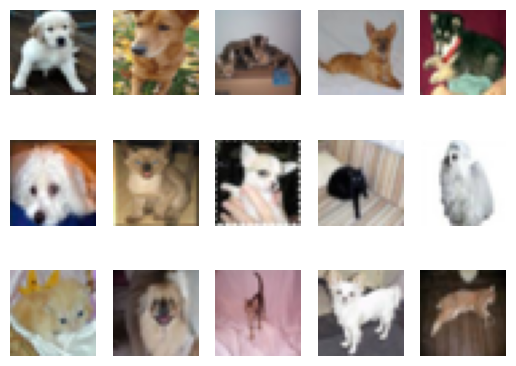

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in val_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
print("Total training examples: ", len(train_loader)) # There are a total of 8000 training examples for the combined cat and dog classes
print("Total validation examples: " , len(val_loader)) # There are a total of 2000 validation examples
print("Total test examples: ", len(test_loader)) # There are a total of 2000 test examples

Total training examples:  8000
Total validation examples:  2000
Total test examples:  2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need a validation set to test our various combinations of hyperparameter values.
 It allows us to detect overfitting or underfitting and compare it to the training set.
 If we were to only to use the training set loss/error, it could the model performing really well with the training set,

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [4]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [5]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [6]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)

for param in large_net.parameters():
    print(param.shape)

print("There are ", 5*3*3*3 + 5 + 245 + 1, "small parameters")
print("There are ", 5*3*5*5 + 5 + 10*5*5*5 + 10 + 32 * 250 + 32 + 32 + 1, "large parameters")

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
There are  386 small parameters
There are  9705 large parameters


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [7]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

The default batch size is 64
the learning rate is 0.01
the number os epochs is 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.319875, Train loss: 0.5905068278312683 |Validation err: 0.3205, Validation loss: 0.6083906032145023
Epoch 2: Train err: 0.30975, Train loss: 0.5848583085536957 |Validation err: 0.342, Validation loss: 0.6189945060759783
Epoch 3: Train err: 0.30475, Train loss: 0.5814946296215058 |Validation err: 0.3165, Validation loss: 0.5972246937453747
Epoch 4: Train err: 0.3035, Train loss: 0.5765783853530884 |Validation err: 0.323, Validation loss: 0.606000492349267
Epoch 5: Train err: 0.298125, Train loss: 0.5718194470405579 |Validation err: 0.3145, Validation loss: 0.5921918312087655
Finished Training
Total time elapsed: 23.42 seconds


There are 4 csv files that contain the training error and loss, as well as the validation error and loss:
- "model_small_bs64_lr0.01_epoch4_train_err.csv" contains the training error
- "model_small_bs64_lr0.01_epoch4_train_loss.csv" contains the training loss
- "model_small_bs64_lr0.01_epoch4_val_err.csv" contains validation error
- "model_small_bs64_lr0.01_epoch4_val_loss.csv" contains validation loss

There are also five checkpoints where the current model is saved:
- "model_small_bs64_lr0.01_epoch0" at epoch 0
- "model_small_bs64_lr0.01_epoch1" at epoch 1
- "model_small_bs64_lr0.01_epoch2" at epoch 2
- "model_small_bs64_lr0.01_epoch3" at epoch 3
- "model_small_bs64_lr0.01_epoch4" at epoch 4


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.295625, Train loss: 0.5673375496864319 |Validation err: 0.3105, Validation loss: 0.5914709605276585
Epoch 2: Train err: 0.287875, Train loss: 0.5631002013683319 |Validation err: 0.319, Validation loss: 0.5902515174821019
Epoch 3: Train err: 0.28825, Train loss: 0.559383695602417 |Validation err: 0.3075, Validation loss: 0.5856206249445677
Epoch 4: Train err: 0.293375, Train loss: 0.5600644299983978 |Validation err: 0.3145, Validation loss: 0.5994032323360443
Epoch 5: Train err: 0.280375, Train loss: 0.552890187740326 |Validation err: 0.3065, Validation loss: 0.5758328270167112
Epoch 6: Train err: 0.28125, Train loss: 0.5475241587162017 |Validation err: 0.292, Validation loss: 0.5795201109722257
Epoch 7: Train err: 0.279875, Train loss: 0.5449734947681427 |Validation err: 0.301, Validation loss: 0.5732828425243497
Epoch 8: Train err: 0.280625, Train loss: 0.5419265604019166 |Validation err:

The small net took 148.22 seconds while the large net took 193.21 seconds.
The large net was visibly slower because there were more parameters, pooling layers,
and convolutional layers in the large net than the small net.


### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

SMALL MODEL


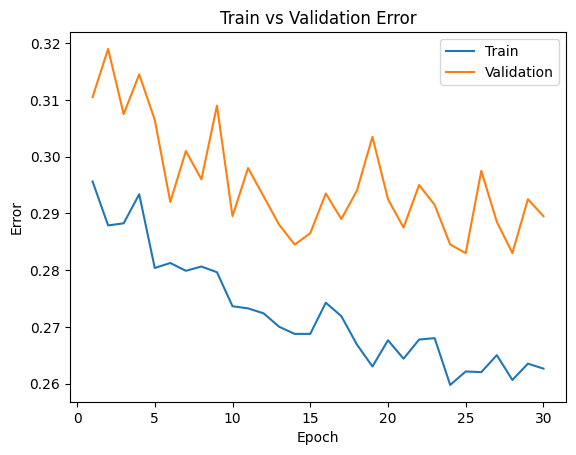

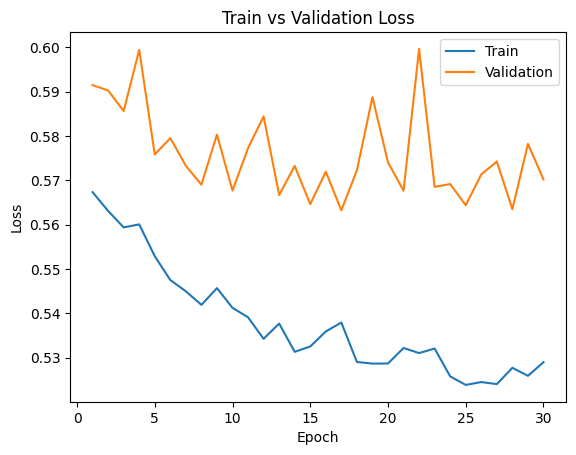

LARGE  MODEL


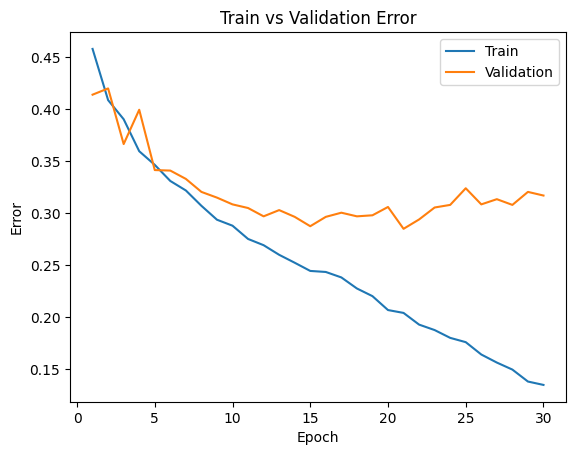

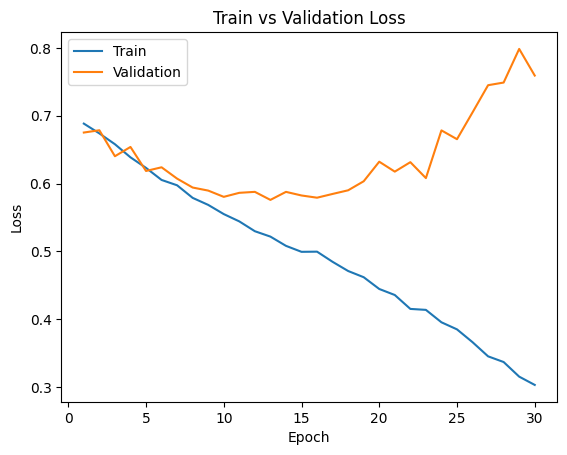

In [ ]:
model_path_small_train = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
print("SMALL MODEL")
plot_training_curve(model_path_small_train)

model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print("LARGE  MODEL")
plot_training_curve(model_path_large)


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.



```
Small Model Training/Validation Error:
  The error is overall on a downwards trend, but varies significantly between
  testing and training. There are many jumps and spikes on the graph, especially in the validation curve.

Small Model Training/Validation Loss:
  This graph shows that there is a significant gap between training and validation curve.
  Both the training and validation curves fluctuate potentially indicating that the learning rate is too high.
  While the general trend is downwards, the training curve does not converge and there is still room for learning.
  This model is underfitted

Large Model Training/Validation Error:
  Both the training and validation error seem to be going in a downwards trend,
  but as the epoch increases, the training error is continuously decreasing, which the validation error remains at around 0.30.

Large Model Training/Validation Loss:
  This model begins with a steep drop, and then slowly the training curve and validation curve begin to diverge around the 8 epoch.
  The training curve still has room to learn, as it has not plateaued.
  However, the validation curve increases in loss as the epoch increases,
  leadering to overfitting.

Compared:
  Overall, the small model shows signs of underfitting with a large gap between the validation and training loss,
  and room for further learning. The large model shows signs of overfitting and has a worse learning ability.
  As well, the small model has many more spikes and fluctuates a lot more than the large model.



```



## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589740753173 |Validation err: 0.4305, Validation loss: 0.6916493494063616
Epoch 3: Train err: 0.43575, Train loss: 0.6916067256927491 |Validation err: 0.4285, Validation loss: 0.6908544301986694
Epoch 4: Train err: 0.43, Train loss: 0.6908613419532776 |Validation err: 0.424, Validation loss: 0.6896595824509859
Epoch 5: Train err: 0.434125, Train loss: 0.6899194955825806 |Validation err: 0.4195, Validation loss: 0.6886935662478209
Epoch 6: Train err: 0.43575, Train loss: 0.688741192817688 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774199485779 |Validation err: 0.4185, Validation loss: 0.6851983051747084
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.41

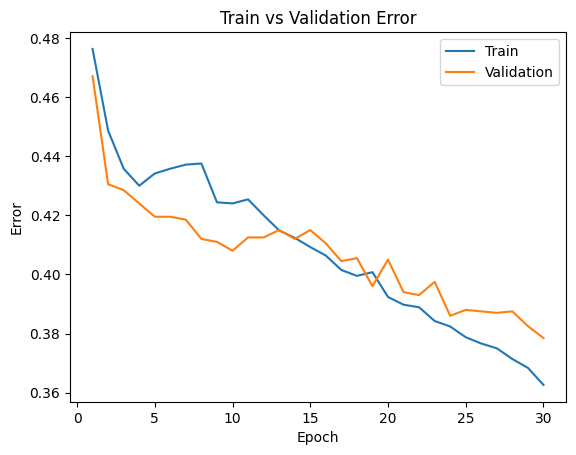

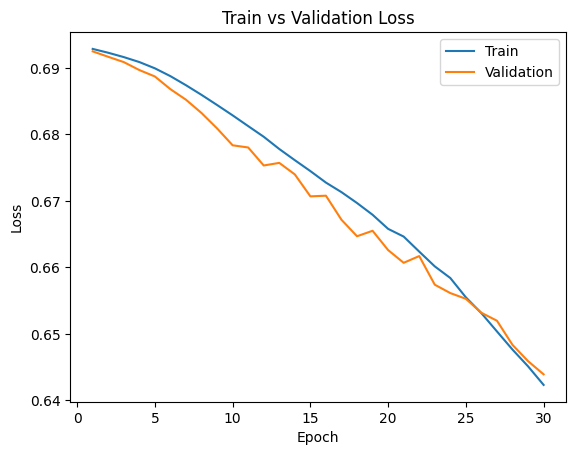

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
print("LARGE  MODEL")
plot_training_curve(model_path_large)


### Effect of lowering the learning rate: large model
  Overall, by lowering the training rate the time taken to train the model decreased. We can see that the training and validation curve are more closely aligned, going in a downwards trend. Overall it took a shorter amount of time to train. At the 30 epoch, there is still room for further training as the fluctuation of loss at the 0 epoch and 30 epoch does not differ by a significant amount. This is a sign of underfitting.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743778004646301 |Validation err: 0.3595, Validation loss: 0.6350856963545084
Epoch 2: Train err: 0.36075, Train loss: 0.6411805462837219 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813464164734 |Validation err: 0.3385, Validation loss: 0.6056603863835335
Epoch 4: Train err: 0.352625, Train loss: 0.623345623254776 |Validation err: 0.3575, Validation loss: 0.6362800160422921
Epoch 5: Train err: 0.34075, Train loss: 0.610801386833191 |Validation err: 0.3305, Validation loss: 0.6064918749034405
Epoch 6: Train err: 0.323375, Train loss: 0.5921835992336273 |Validation err: 0.317, Validation loss: 0.5967769687995315
Epoch 7: Train err: 0.3145, Train loss: 0.5817317562103271 |Validation err: 0.3365, Validation loss: 0.6204487904906273
Epoch 8: Train err: 0.29825, Train loss: 0.5660300071239471 |Validation err: 0.

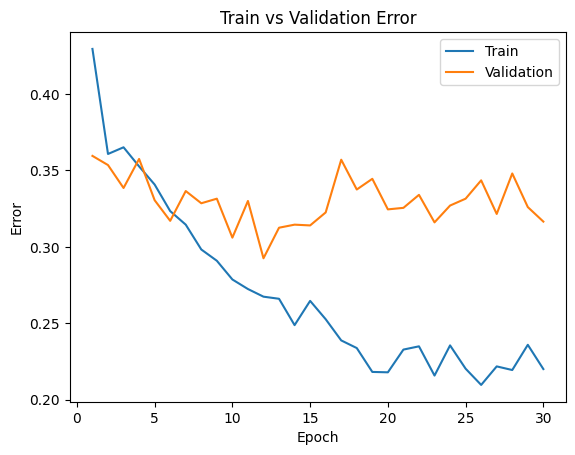

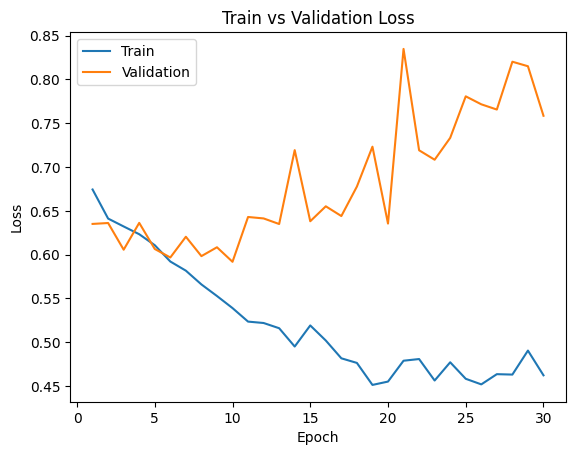

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
print("LARGE  MODEL")
plot_training_curve(model_path_large)

### Effect of increasing the learning rate: Large Model
  Overall, the time taken to train the model has decreased,
  By increasing the learning rate there are signs of overfitting and rapid change in training and validation curve. This could mean that the learning rate is too large and cannot capture the points in between. Overfitting also remains as a problem and has worsened with the increase of learning rate, as we can see that near the 6 epoch the two curves begin to diverge and end up diverging significantly as the epoch increases.




### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871751844883 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, V

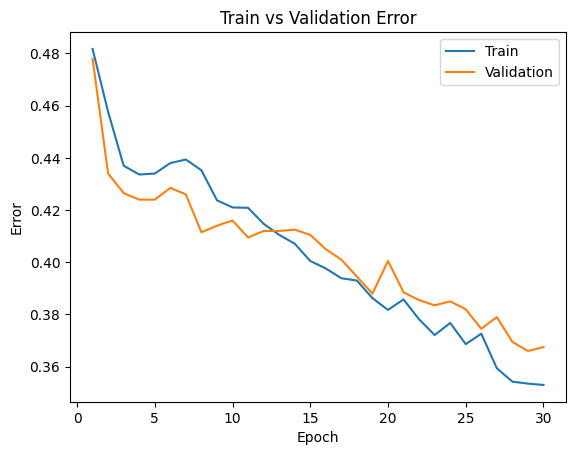

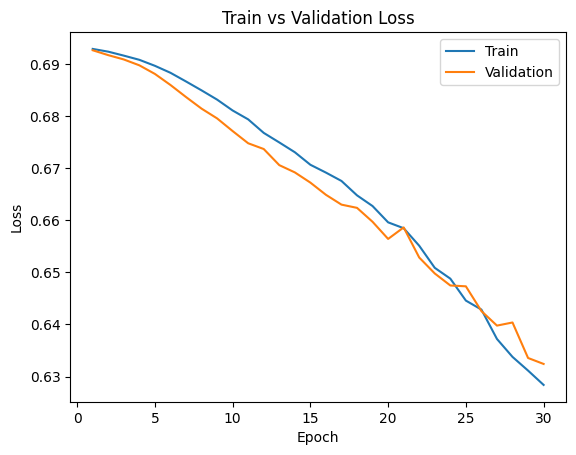

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
print("LARGE  MODEL")
plot_training_curve(model_path_large)

### Effect of increasing the batch size: Large Model
  Overall by increasing the batch size the training time decreases. Increasing the batch size also helps with aligning the training curve and validation curve, and reducing the overall error. It also helps reduce the overfitting in the default parameter model, but could now be underfitting. There is more room for learning after the 30 epoch.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994033575058 |Validation err: 0.382, Validation loss: 0.6513170146942139
Epoch 2: Train err: 0.369, Train loss: 0.6396398993134499 |Validation err: 0.3465, Validation loss: 0.6161113579273224
Epoch 3: Train err: 0.34375, Train loss: 0.6098222960829734 |Validation err: 0.3325, Validation loss: 0.6260210766792297
Epoch 4: Train err: 0.314375, Train loss: 0.584969149172306 |Validation err: 0.34, Validation loss: 0.6044013905525207
Epoch 5: Train err: 0.301125, Train loss: 0.5689119317531586 |Validation err: 0.3125, Validation loss: 0.5769183149337769
Epoch 6: Train err: 0.281, Train loss: 0.5452213580608368 |Validation err: 0.308, Validation loss: 0.570844743013382
Epoch 7: Train err: 0.270875, Train loss: 0.5272981309890747 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.507090549826622 |Validation err: 0.313, V

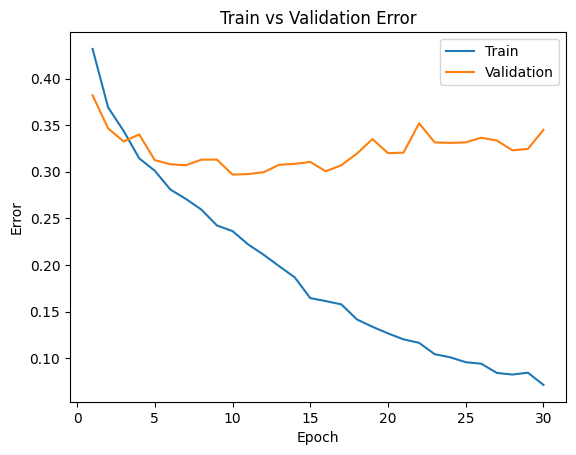

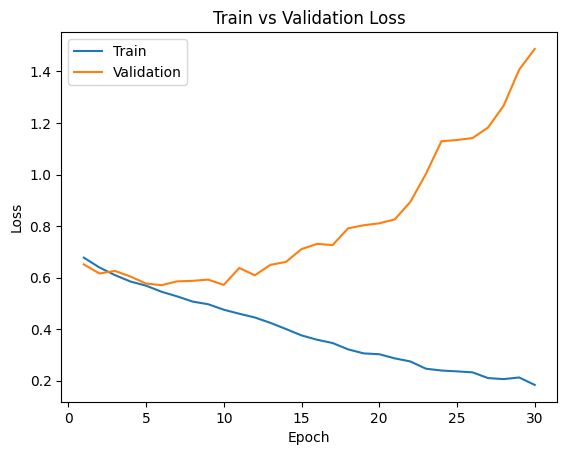

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)
model_path_large = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
print("LARGE  MODEL")
plot_training_curve(model_path_large)

### Effect of decreasing the batch size: Large Model
  Overall the training time due to decreasing the batch size is longer than the default parameters. This could be due to having to divide up the data into smaller chunks and therefore going through more cycles. Compared to the default parameters overfitting has gotten worse. The validation curve increases significantly after the fifth epoch, and the validation error hovers around 0.30 with a slight increase at the end.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

### Using the small model: decrease the learning rate
  I observe that in the large model, there tends to be instances of overfitting when batch size decreased and learning rate increased. But there also seems to be signs of underfitting once the batch size is increased and the learning rate is increased. This could potentially mean that the model is too complicated or the validation data is undersampled. We have yet to experiment with the small model. The small model shows many spikes which could mean the the learning rate is too high and needs to be decreased. By decreasing the learning rate we would be able to produce a smoother training and validation curve. Since the small model trains at a faster time we might be able to increase the number of epoch significantly later to see where is converges.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.463125, Train loss: 0.6894975113868713 |Validation err: 0.4425, Validation loss: 0.6834452152252197
Epoch 2: Train err: 0.4235, Train loss: 0.6801317744255065 |Validation err: 0.4175, Validation loss: 0.6760942544788122
Epoch 3: Train err: 0.409625, Train loss: 0.6733395314216614 |Validation err: 0.4075, Validation loss: 0.6696472316980362
Epoch 4: Train err: 0.397875, Train loss: 0.6683243737220764 |Validation err: 0.401, Validation loss: 0.6634480096399784
Epoch 5: Train err: 0.3935, Train loss: 0.6647757997512818 |Validation err: 0.3955, Validation loss: 0.6634267326444387
Epoch 6: Train err: 0.387125, Train loss: 0.6614563946723938 |Validation err: 0.3955, Validation loss: 0.6619470771402121
Epoch 7: Train err: 0.385, Train loss: 0.6583882060050964 |Validation err: 0.3885, Validation loss: 0.6608655620366335
Epoch 8: Train err: 0.382625, Train loss: 0.6554060144424438 |Validation err: 

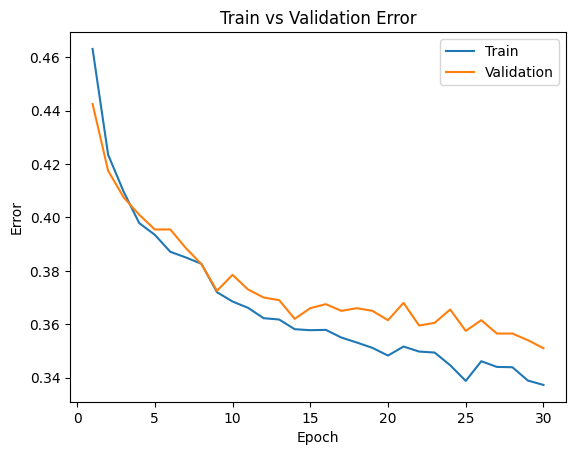

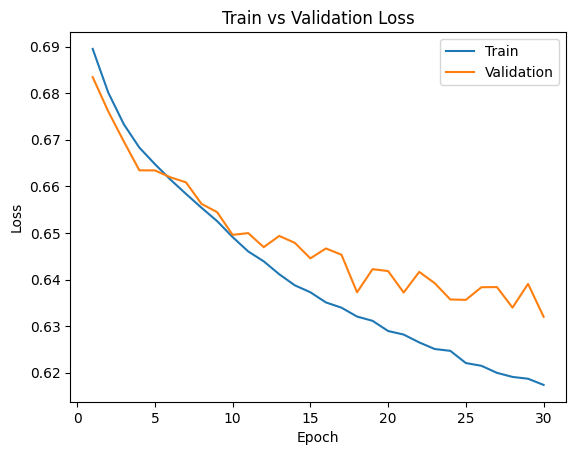

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=64, learning_rate=0.001, num_epochs=30)
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.001, epoch=29)
print("SMALL  MODEL")
plot_training_curve(model_path_small)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

### Increasing Batch Size, Increasing the Epochs
   The training and validation curve is now a lot less noisy compared to a higher learning rate. There are now signs of overfitting and a unstable validation curve. We would potentially increase the batch size so that each step has more training examples to reduce spikes. Near the 30th epoch, the training curve is still going downwards, showing room for learning. If we increase the number of epoch, we can see if the graph ends up flattening.

### Part (d) - 1pt
Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.5145, Train loss: 0.707811314612627 |Validation err: 0.523, Validation loss: 0.7004823684692383
Epoch 2: Train err: 0.523875, Train loss: 0.6988230310380459 |Validation err: 0.5185, Validation loss: 0.6971128284931183
Epoch 3: Train err: 0.508625, Train loss: 0.6958687342703342 |Validation err: 0.492, Validation loss: 0.6947224736213684
Epoch 4: Train err: 0.488, Train loss: 0.6935285143554211 |Validation err: 0.4825, Validation loss: 0.6921024471521378
Epoch 5: Train err: 0.477, Train loss: 0.6912660226225853 |Validation err: 0.476, Validation loss: 0.6897109597921371
Epoch 6: Train err: 0.461, Train loss: 0.689423993229866 |Validation err: 0.461, Validation loss: 0.6877316236495972
Epoch 7: Train err: 0.455625, Train loss: 0.687686026096344 |Validation err: 0.446, Validation loss: 0.6859051734209061
Epoch 8: Train err: 0.452875, Train loss: 0.6860525049269199 |Validation err: 0.4365, Val

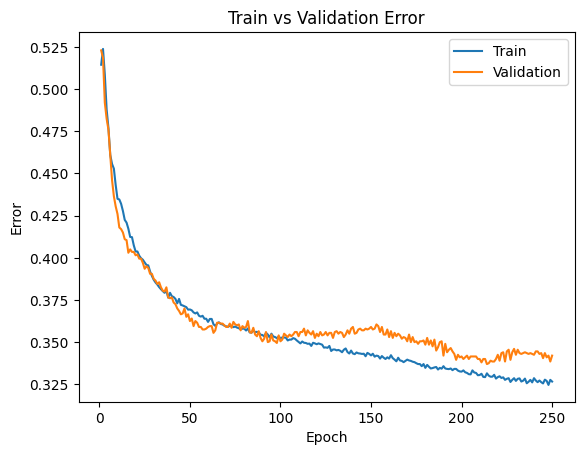

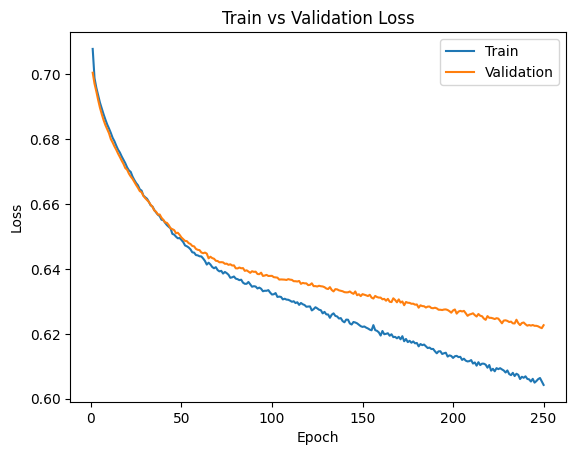

In [ ]:
# decrease learning rate, increase epoch, increase batch size
small_net = SmallNet()
train_net(small_net, batch_size=512, learning_rate=0.001, num_epochs=250)
model_path_small = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=249)
print("SMALL  MODEL")
plot_training_curve(model_path_small)

### Part(e) - that no one asked for
  Seeing how the small model tends to diverge as the number of epoch increases, I would like to go back to the big model and increase the number of epoch with decreased learning rate and increased batch size. As decreasing the learning rate can help with less fluctuation and increased batch size helps reduce overfitting.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6946656666696072 |Validation err: 0.491, Validation loss: 0.6939187347888947
Epoch 2: Train err: 0.50225, Train loss: 0.6945646665990353 |Validation err: 0.491, Validation loss: 0.6938043832778931
Epoch 3: Train err: 0.50225, Train loss: 0.6943127699196339 |Validation err: 0.491, Validation loss: 0.6936505287885666
Epoch 4: Train err: 0.50225, Train loss: 0.6941213682293892 |Validation err: 0.491, Validation loss: 0.69350565969944
Epoch 5: Train err: 0.50225, Train loss: 0.6940221525728703 |Validation err: 0.491, Validation loss: 0.6934881210327148
Epoch 6: Train err: 0.502125, Train loss: 0.6938703320920467 |Validation err: 0.491, Validation loss: 0.6934278756380081
Epoch 7: Train err: 0.50225, Train loss: 0.6938018389046192 |Validation err: 0.491, Validation loss: 0.6933837682008743
Epoch 8: Train err: 0.502, Train loss: 0.6936991885304451 |Validation err: 0.4905, Va

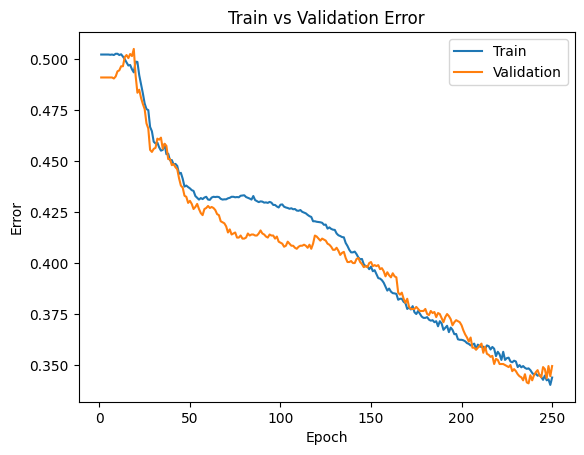

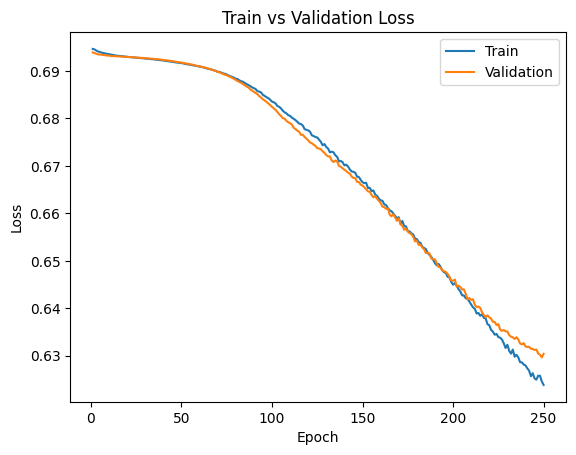

In [13]:
# decrease learning rate, increase epoch, increase batch size
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001, num_epochs=250)
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=249)
print("LARGE  MODEL")
plot_training_curve(model_path_large)

### Part (f)
  Decreasing # epoch in previous small model. For myself, do not mark.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.508, Train loss: 0.6977777779102325 |Validation err: 0.513, Validation loss: 0.6965532004833221
Epoch 2: Train err: 0.4935, Train loss: 0.6950152777135372 |Validation err: 0.4915, Validation loss: 0.6934622675180435
Epoch 3: Train err: 0.47975, Train loss: 0.693225234746933 |Validation err: 0.482, Validation loss: 0.6919800788164139
Epoch 4: Train err: 0.473, Train loss: 0.6919130086898804 |Validation err: 0.472, Validation loss: 0.6906810849905014
Epoch 5: Train err: 0.464125, Train loss: 0.6904340833425522 |Validation err: 0.456, Validation loss: 0.6893652528524399
Epoch 6: Train err: 0.4575, Train loss: 0.6894184499979019 |Validation err: 0.4505, Validation loss: 0.6881870478391647
Epoch 7: Train err: 0.450625, Train loss: 0.6881065107882023 |Validation err: 0.448, Validation loss: 0.6870236098766327
Epoch 8: Train err: 0.443, Train loss: 0.687056191265583 |Validation err: 0.4445, Valid

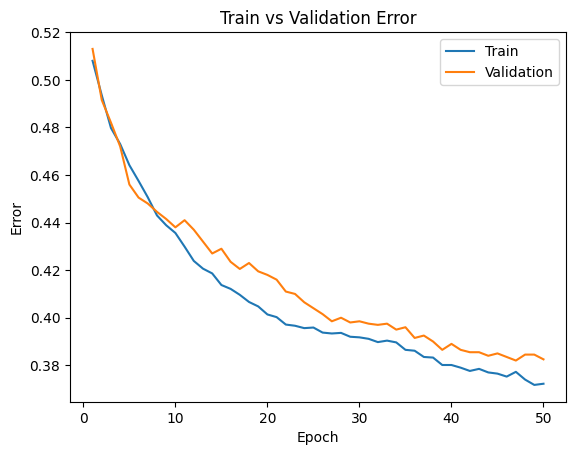

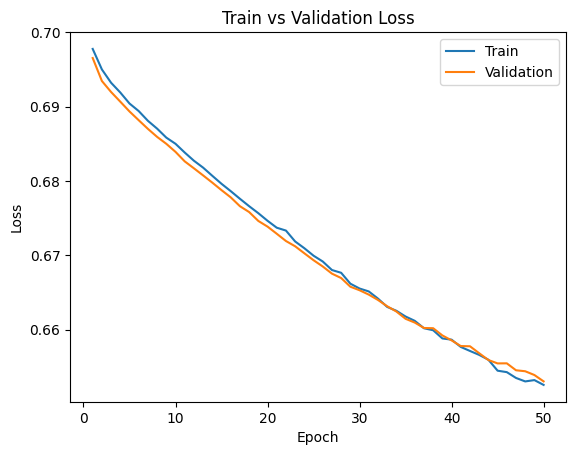

In [8]:
train_net(small_net, batch_size=512, learning_rate=0.001, num_epochs=50)
model_path_small = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=49)
print("SMALL  MODEL")
plot_training_curve(model_path_small)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [14]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.001, epoch=249)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I chose to use the large model, batch size 512, learning rate of 0.001, and epoch number 250. Overall, The training curve and validation curve display a downward trend, with decreasing losses and errors as epoch continues. There isn't as much fluctuation with a faster learning rate, and increasing the batch size helps with overfitting. Overall, it's a more stable model and a more fitting validation curve.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [15]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)

test_error, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("Test Error：", test_error)
print("Test Loss: ", test_loss)

Files already downloaded and verified
Files already downloaded and verified
Test Error： 0.3415
Test Loss:  0.6211681421846151


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [16]:
val_error, val_loss = evaluate(net, val_loader, nn.BCEWithLogitsLoss())
print("Validation Error：", val_error)
print("Validation Loss: ", val_loss)

Validation Error： 0.3495
Validation Loss:  0.6287204194813967


Unexpectedly my test classification error is lower than my validation error. Typically we should expect the test error to be higher because of the model's infamiliarity with the testing dataset. In my case it can be that the testing dataset happens to be easier to classify.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The test dataset is used at the very end because we want the model to use new data and see its learning outcomes. If the model gets very good at reducing loss and error for one set of data, but shows no learning with a subset of the original dataset, it has low learning capabilities. This leads to bias, and it will only optimize for that specific dataset. The testing data is new and the model has never seen before, so it can be used to evaluate it's true performance.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4815, Train loss: 0.6921891421079636 |Validation err: 0.443, Validation loss: 0.6849011033773422
Epoch 2: Train err: 0.431875, Train loss: 0.6825137138366699 |Validation err: 0.436, Validation loss: 0.6772310733795166
Epoch 3: Train err: 0.418125, Train loss: 0.676270728930831 |Validation err: 0.434, Validation loss: 0.673106238245964
Epoch 4: Train err: 0.41225, Train loss: 0.6711958665400743 |Validation err: 0.421, Validation loss: 0.6700495108962059
Epoch 5: Train err: 0.40575, Train loss: 0.6679403390735388 |Validation err: 0.4105, Validation loss: 0.6679195240139961
Epoch 6: Train err: 0.404, Train loss: 0.6665613315999508 |Validation err: 0.4065, Validation loss: 0.6666593998670578
Epoch 7: Train err: 0.4015, Train loss: 0.6642101369798183 |Validation err: 0.404, Validation loss: 0.6651891320943832
Epoch 8: Train err: 0.3975, Train loss: 0.6626701727509499 |Validation err: 0.4055, Va

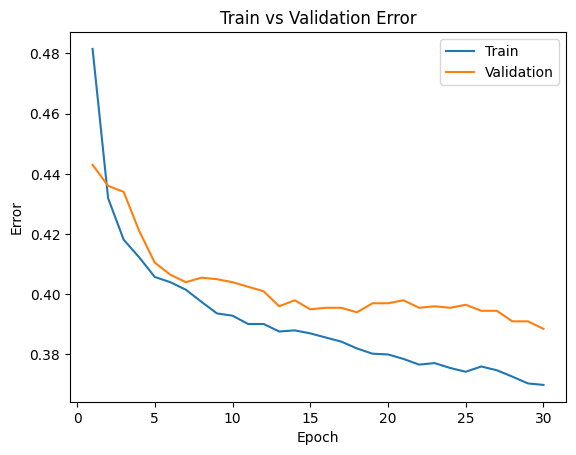

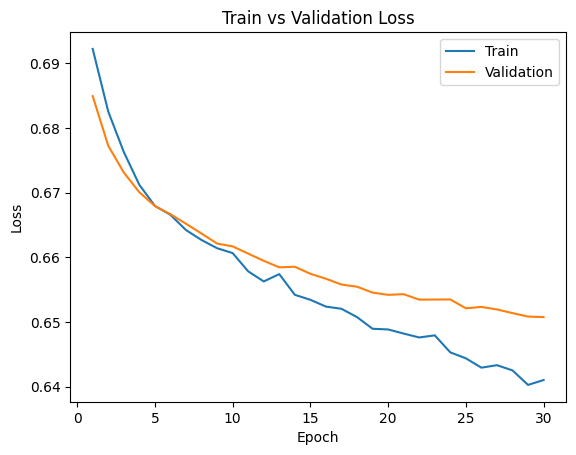

In [22]:
torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class CatDogNet(nn.Module):
    def __init__(self):

        super(CatDogNet, self).__init__()
        self.name = "cat_dog_ann"
        self.layer1 = nn.Linear(3* 32 * 32, 30) # used 300 and 3000 for second parameter for changing hidden values
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1) # used softplus and silu
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

cat_dog_ann = CatDogNet()
train_net(cat_dog_ann, batch_size=256, learning_rate=0.0005, num_epochs=30)

model_cat_dog = get_model_name("cat_dog_ann", batch_size=256, learning_rate=0.0005, epoch=29)
print("CAT DOG ANN")
plot_training_curve(model_cat_dog)





In [23]:
val_error, val_loss = evaluate(cat_dog_ann, val_loader, nn.BCEWithLogitsLoss())
print("Validation Error：", val_error)
print("Validation Loss: ", val_loss)

test_error, test_loss = evaluate(cat_dog_ann, test_loader, nn.BCEWithLogitsLoss())
print("Test Error：", test_error)
print("Test Loss: ", test_loss)

Validation Error： 0.3885
Validation Loss:  0.6528794206678867
Test Error： 0.368
Test Loss:  0.6471942327916622


Overall, the CNN outperforms the ANN at classifying cats and dogs. The CNN is able to take in more inputs and can work with higher dimensions.